# ResNet50 SAHP 분석
- 주의사항 (데이터 차원 관련)
    - ResNet50은 입력 데이터에 (1, C, H, W) 즉, (batch, channel, height, width) 형식을 기대함 (예: [1, 3, 224, 224])
    - 그러나 SHAP는 (H, W, C) 형식 입력을 기대하기 때문에 변환이 필요 - (예: [224, 224, 3])

In [23]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import shap
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [24]:
# ResNet50 모델 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU 사용시를 상정하여 작성
model = models.resnet50(weights=None) # 가중치 없는 모델
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3) # 클래스 3개
model.load_state_dict(torch.load("best_model.pth", map_location=device)) # 저장된 모델 불러오기기 
model.to(device)
model.eval() # 모델을 평가 모드로 전환

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# 모델의 fc레이어 확인 - 참고용
print(model.fc)

Linear(in_features=2048, out_features=3, bias=True)


In [26]:
# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 이미지 로드 및 변환 함수
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0) # 배치 차원 추가 (1, C, H, W)
    return image_tensor.to(device) # GPU 사용 시를 상정하여 텐서를 특정 장치로 이동시키도록 .to(device)

# 모델 예측 함수
def model_forward(x):
    # SHAP explainer에 입력할 모델 예측 함수
    x_tensor = torch.tensor(x).permute(0, 3, 1, 2).to(device) # (batch, H, W, C) → (batch, C, H, W)
    with torch.no_grad():
        logits = model(x_tensor) # 모델 예측 수행 (logits 값 출력)
        probabilities = F.softmax(logits, dim=1) # 확률 값으로 변환
    return probabilities.cpu().numpy() # numpy 배열로 변환

In [27]:
# SHAP partition explainer 설정
# SHAP 마스킹 방식 설정 (이미지 차원: 224x224, 3)
masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))

# SHAP Explainer 정의
explainer = shap.Explainer(model_forward, masker)

In [28]:
# 분석할 이미지 로드 및 전처리
image_path = r"C:\Users\USER\Desktop\my_git\data-science-experiments\safebaby_ai_model\data\back\back_0032.jpeg" # 분석할 이미지 경로 입력
image_tensor = preprocess_image(image_path).to(device)

# 클래스명 정의
class_name = ["Back", "Front", "Side"]

# 모델 예측 수행
output = model(image_tensor)
probabilities = torch.nn.functional.softmax(output, dim=1) # 확률 변환

# 결과 출력
print("결과 : ", output)
print("예측 확률 :", probabilities)
predicted_class = torch.argmax(probabilities, dim=1).item()
print(f"Predicted Class Index: {predicted_class} -> Class Name: {class_name[predicted_class]}")

결과 :  tensor([[ 1.6698e+00, -2.0444e-03, -2.3215e+00]], grad_fn=<AddmmBackward0>)
예측 확률 : tensor([[0.8289, 0.1558, 0.0153]], grad_fn=<SoftmaxBackward0>)
Predicted Class Index: 0 -> Class Name: Back


변환된 이미지 크기: (224, 224, 3)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.41s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


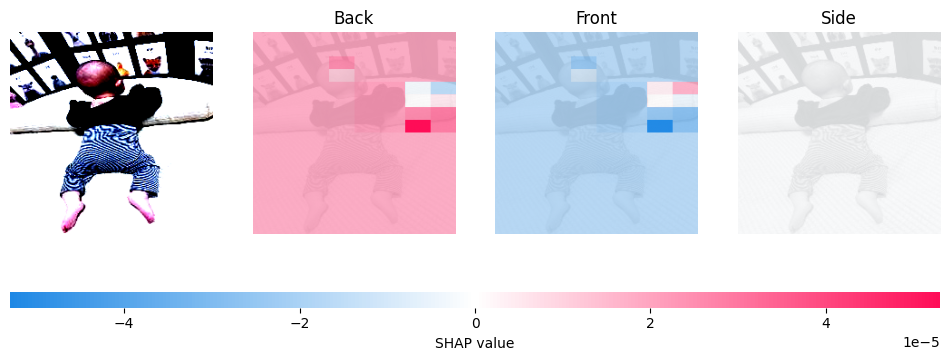

In [29]:
# 올바른 차원 변환 적용 (1, C, H, W, -> H, W, C)
image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# 차원 확인
print("변환된 이미지 크기:", image_numpy.shape) # (224, 224, 3) 확인

# SHAP 값 계산
shap_values = explainer(np.expand_dims(image_numpy, axis=0), max_evals=500, batch_size=50)

# 시각화
shap.image_plot(shap_values, np.expand_dims(image_numpy, axis=0), labels=class_name)

## V5 모델 오분류 이미지 분석

In [44]:
import os
import glob
import torch
import torchvision.transforms as transforms
from PIL import Image
import shap
import numpy as np

In [59]:
classes = ["back", "front", "side"]

In [60]:
# 모델 예측 함수 (ResNet50 예측)
def predict_class(img_tensor):
    model.eval()  # 모델을 평가 모드로 설정
    with torch.no_grad():
        logits = model(img_tensor)  # 모델 추론
        probs = F.softmax(logits, dim=1)  # 확률값 변환
        pred_class = torch.argmax(probs, dim=1).item()  # 가장 높은 확률의 클래스 선택
    return pred_class, probs.cpu().numpy()  # 예측 클래스 ID와 확률 반환

In [45]:
# 폴더에서 리스트 불러오기
misclassified_path = r"C:\Users\USER\Desktop\my_git\safebaby-xai\resnet50_explain\resnet50_sample_data\V5\back"
image_paths = glob.glob(os.path.join(misclassified_path, "*.png"))

# 여러개의 이미지를 불러와서 tensor로 변환환
image_tensors = torch.cat([preprocess_image(img) for img in image_paths])

print(f"Loaded {len(image_paths)} images into tensor shape: {image_tensors.shape}")

Loaded 46 images into tensor shape: torch.Size([46, 3, 224, 224])


In [62]:
import numpy as np

# 마스킹 방식 설정
masker = shap.maskers.Image("inpaint_telea", (224, 224, 3))
# SHAP 생성성
explainer = shap.Explainer(model_forward, masker)
# SHAP 실행 전 입력 데이터 변환 (batch, C, H, W → batch, H, W, C)
image_array_shap = image_tensors.cpu().numpy().transpose(0, 2, 3, 1)  # (batch, 3, 224, 224) → (batch, 224, 224, 3)
# 2. 변환된 차원 확인
print(f"SHAP에 맞게 차원 변환: {image_array_shap.shape}")  # (batch, 224, 224, 3)이어야 함
# 3. SHAP Explainer 실행
shap_values = explainer(image_array_shap)

SHAP에 맞게 차원 변환: (46, 224, 224, 3)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   2%|▏         | 1/46 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   7%|▋         | 3/46 [01:51<17:58, 25.08s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   9%|▊         | 4/46 [02:23<19:45, 28.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  11%|█         | 5/46 [03:02<22:01, 32.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  13%|█▎        | 6/46 [03:44<23:49, 35.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 7/46 [04:23<23:55, 36.80s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 7/46 [05:04<33:00, 50.78s/it]


KeyboardInterrupt: 

### 시각화 주의사항
- 여러장 분석시 labels가 1차원 리스트가 아닌 (1, n)형식이어야 함 -  (배치차원, 레이블(분석할이미지) 수)
- 46장 분석시 (1, 46)의 labels를 기대하지만 (46,)크기가 전달되면 오류 발생

c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\shap\plots\_image.py:142: RuntimeWarning: invalid value encountered in divide
  x_curr_disp = (means - np.percentile(means, 0.5, (0, 1))) / (
c:\Users\USER\anaconda3\envs\ds_env\Lib\site-packages\shap\plots\_image.py:142: RuntimeWarning: invalid value encountered in divide
  x_curr_disp = (means - np.percentile(means, 0.5, (0, 1))) / (


IndexError: index 1 is out of bounds for axis 0 with size 1

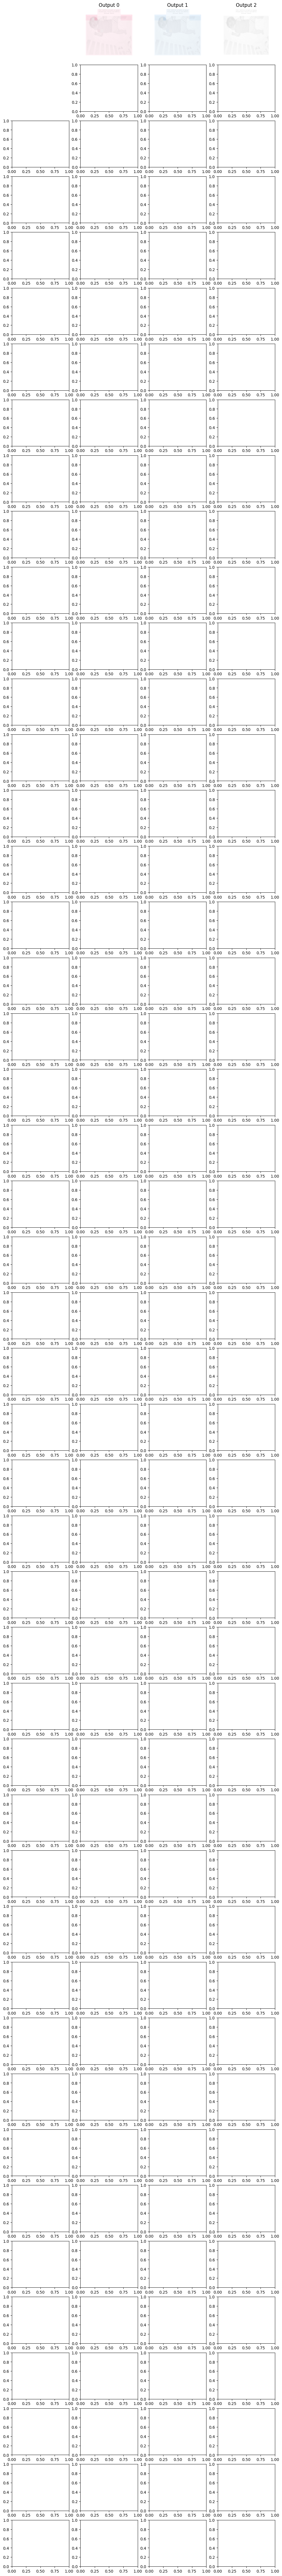

In [ ]:
# SHAP 결과 시각화
shap.image_plot(shap_values, np.array([np.array(Image.open(img)) for img in image_paths]))